In [75]:
%matplotlib inline
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

## Filepath to catalog file
infile = '/home/asnyder/DATA/BOT/6865D_dither/MC_C_20191031_001500_R02_S02_20.0s_-293.2x_39.6y_gridfit.cat'

## Open a Catalog File Using Astropy

We'll begin by exploring a single catalog file, using the `astropy` python module. Here the file is opened using `astropy.io.fits.open()` (Note: that during the import step this name has been shortened for readability).

This will return an `HDUList` of `HDU` objects, where each `HDU` corresponds to a header section and a table of results. First, let's print out the number of items in the `HDUList` and the header of the first `HDU`, which is the `PrimaryHDU`.

In [59]:
## Open the FITS object
hdulist = fits.open(infile)

print("Number of HDUs: {0}".format(len(hdulist)))

prihdu = hdulist[0]
prihdr = prihdu.header

print(repr(prihdr))

Number of HDUs: 7
SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 


The catalog files are the output of a series of analysis tasks implemented within the LSST Data Management software stack that are designed to detect astronomical objects and measure a series of properties for each detected object.  These properties are included in the second `HDU` in the `HDUList`, which can be accessed by using the index 1 (Note: Items in an `HDUList` are accessed the same way as a normal Python `list` and are zero-indexed).

To see the names of the measured properties we access the catalog `HDU` and print out the names of the columns.

In [60]:
catalog_hdu = hdulist[1]
catalog_data = catalog_hdu.data

for col in catalog_data.columns:
    print(col.name)

flags
id
coord_ra
coord_dec
parent
base_NaiveCentroid_x
base_NaiveCentroid_y
base_SdssCentroid_x
base_SdssCentroid_y
base_SdssCentroid_xErr
base_SdssCentroid_yErr
base_Blendedness_old
base_Blendedness_raw
base_Blendedness_raw_child_instFlux
base_Blendedness_raw_parent_instFlux
base_Blendedness_abs
base_Blendedness_abs_child_instFlux
base_Blendedness_abs_parent_instFlux
base_Blendedness_raw_child_xx
base_Blendedness_raw_child_yy
base_Blendedness_raw_child_xy
base_Blendedness_raw_parent_xx
base_Blendedness_raw_parent_yy
base_Blendedness_raw_parent_xy
base_Blendedness_abs_child_xx
base_Blendedness_abs_child_yy
base_Blendedness_abs_child_xy
base_Blendedness_abs_parent_xx
base_Blendedness_abs_parent_yy
base_Blendedness_abs_parent_xy
base_SdssShape_xx
base_SdssShape_yy
base_SdssShape_xy
base_SdssShape_xxErr
base_SdssShape_yyErr
base_SdssShape_xyErr
base_SdssShape_x
base_SdssShape_y
base_SdssShape_instFlux
base_SdssShape_instFluxErr
base_SdssShape_psf_xx
base_SdssShape_psf_yy
base_SdssShape_p

To see where the detected sources were located on the CCD, let's make a scatter plot of all the detected source positions, using the measurements `base_SdssCentroid_x` and `base_SdssCentroid_y` corresponding to source centroid measurements made using the SDSS algorithm.

Text(0.5, 0, 'Pixel X')

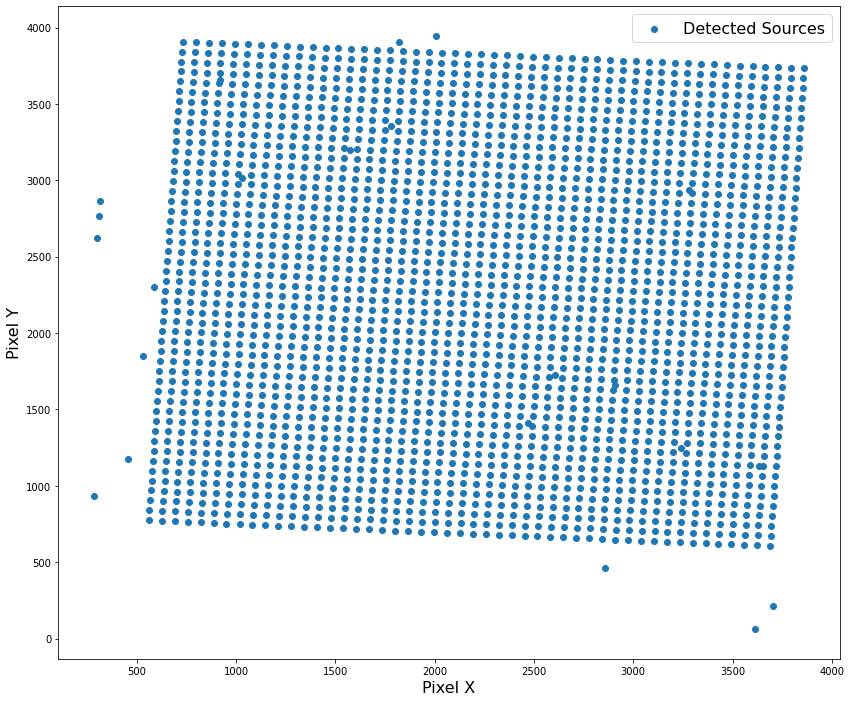

In [61]:
source_x = catalog_data['base_SdssCentroid_x']
source_y = catalog_data['base_SdssCentroid_y']

fig, ax = plt.subplots(1, 1, figsize=(14, 12))
ax.scatter(source_x, source_y, label='Detected Sources')
ax.legend(fontsize=16)
ax.set_ylabel('Pixel Y', fontsize=16)
ax.set_xlabel('Pixel X', fontsize=16)

The pattern of fake stars projected onto the CCD is a 49 by 49 grid of spots. This can be seen in the above plot; additionally a number of "false positives" are seen, corresponding to cosmic rays or pixel defects that have been wrongly identified as sources as well.

The catalog also contains information on the detected sources brightness, which can also be plotted as a scatter plot to learn more about the illumination pattern. Below the plots show Flux and the sum of the XX and YY moments, all calculated using the SDSS weighted moment algorithm.

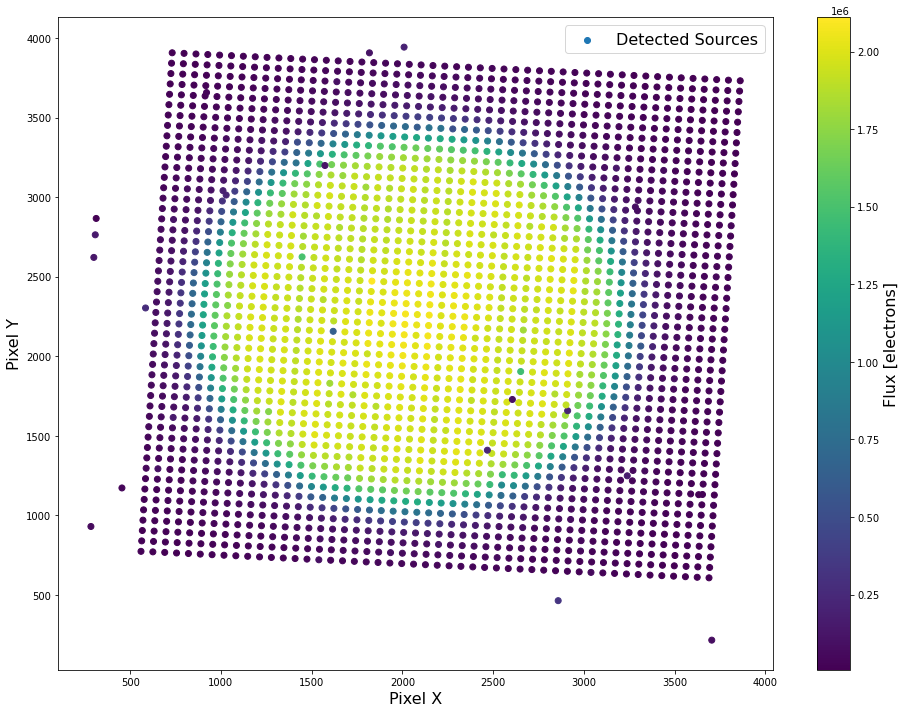

In [62]:
source_flux = catalog_data['base_SdssShape_instFlux']

fig, ax = plt.subplots(1, 1, figsize=(16, 12))
im = ax.scatter(source_x, source_y, c=source_flux, label='Detected Sources')
ax.legend(fontsize=16)
ax.set_ylabel('Pixel Y', fontsize=16)
ax.set_xlabel('Pixel X', fontsize=16)
cbar = fig.colorbar(im)
cbar.set_label('Flux [electrons]', fontsize=16)

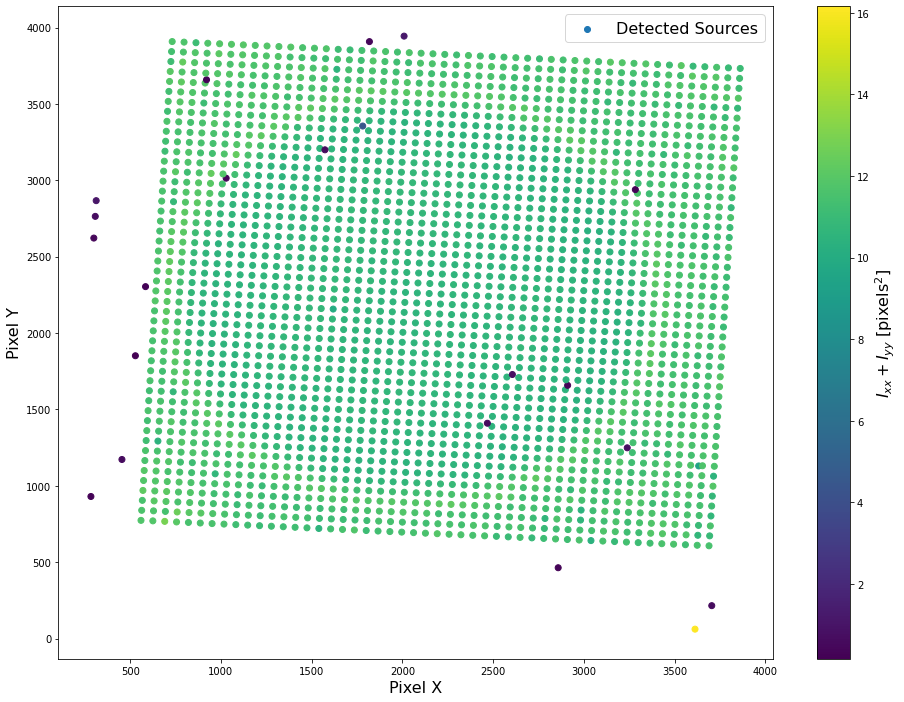

In [63]:
source_xx = catalog_data['base_SdssShape_xx']
source_yy = catalog_data['base_SdssShape_yy']

fig, ax = plt.subplots(1, 1, figsize=(16, 12))
im = ax.scatter(source_x, source_y, c=source_xx+source_yy, label='Detected Sources')
ax.legend(fontsize=16)
ax.set_ylabel('Pixel Y', fontsize=16)
ax.set_xlabel('Pixel X', fontsize=16)
cbar = fig.colorbar(im)
cbar.set_label(r'$I_{xx} + I_{yy}$ [$\mathrm{pixels}^2$]', fontsize=16)

The projected grid suffers from vignetting from the projector optics, resulting in a sharp decrease in flux for fake stars that are further from the center of the projected grid of sources.

By looking at the second moments it is easy to identify the "false positives", which are overwhelmingly much smaller in source width than the fake stars. 

## Matching an Ideal Grid to the Detected Sources

In order to study sensor effects that occur at specific pixel positions on the CCD it is necessary to be able to uniquely identify each fake star and trace how its properties change as it moves across the CCD.

The algorithm to fit an ideal grid to the detected sources has already been run and the information has been added to the source catalog.  This includes:

* `spotgrid_index` is the index of the spot in the flattened array of grid spots
* `spotgrid_y` is the ideal position of the corresponding spot in the grid.
* `spotgrid_x` is the ideal position of the corresponding spot in the grid.

The detected sources that do not correspond to a spot in the projected grid will not have entries for these columns, and they can be used to filter out the "false positives".

Below we compare the centroids of the detected sources to the position of the ideal spots in the projected grid. Notice that these are not the same, largely due to distortions from the optics of the spot projector.

Text(0.5, 0, 'Pixel X')

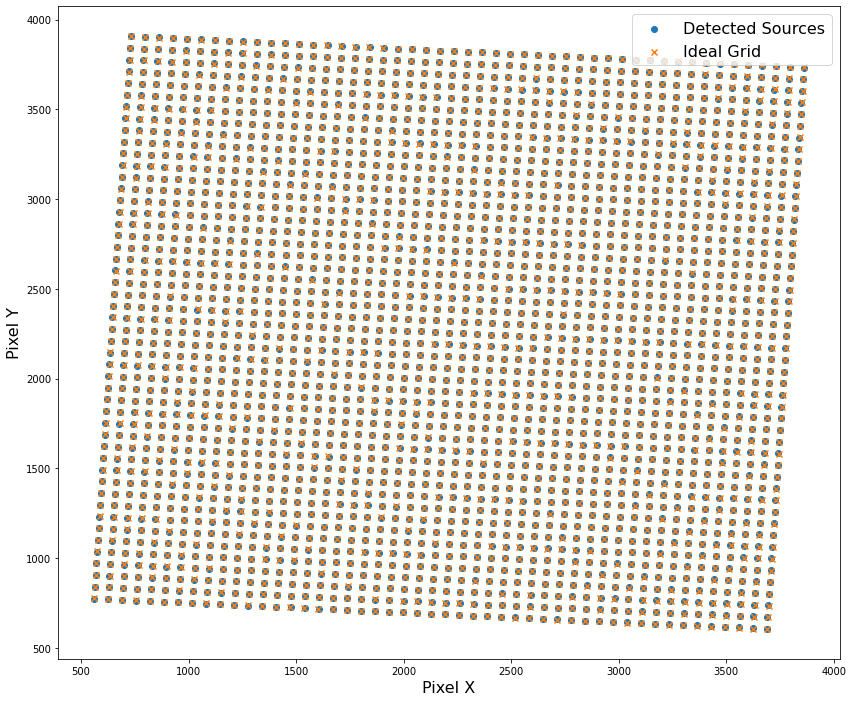

In [82]:
idx = catalog_data['spotgrid_index'] >= 0.
grid_x = catalog_data['spotgrid_x']
grid_y = catalog_data['spotgrid_y']

fig, ax = plt.subplots(1, 1, figsize=(14, 12))

ax.scatter(source_x[idx], source_y[idx], label='Detected Sources')
ax.scatter(grid_x[idx], grid_y[idx], label='Ideal Grid', marker='x')
ax.legend(fontsize=16)
ax.set_ylabel('Pixel Y', fontsize=16)
ax.set_xlabel('Pixel X', fontsize=16)